# Examining Physics Using the Interpolation Method

Now that we have generated our clusters and estimated the physical observables of interest we are ready to initiate the solving phase of the analysis, where we attempt to extract the exact physics observables by fitting solutions of the equations of motion to the data. There are several approaches to solving in this application, and this notebook looks at what is referred to as the interpolation method. The interpolation method works by pre-generating a bunch of solutions to the ODE's and then interpolation on these solutions to try and fit the data. It has the advantage of being very fast; the ODE's only ever need to be solved once, and then all the remaining calculation is just simple (bi)linear interpolation.

First let's take care of all of our imports.

Note: this notebook assumes you've already done the work of generating the interpolation scheme. This is done by simply running phase 4 in the main application with an interpolation scheme defined. This can take some time (20-30 min depending on the coarse-ness of the grid).

In [1]:
import sys
sys.path.append('..')
from spyral.core.cluster import Cluster
from spyral.core.track_generator import create_interpolator
from spyral.core.config import load_config
from spyral.core.workspace import Workspace
from spyral.core.particle_id import load_particle_id
from spyral.core.target import Target
from spyral.solvers.solver_interp import fit_model_interp, Guess, interpolate_trajectory

import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import h5py as h5
import numpy as np

Now with all of our code imported we will setup the configuration, loading our config file and creating all of our data structures

In [2]:
config = load_config('../local_config.json')
ws = Workspace(config.workspace)
track_path = ws.get_track_file_path(config.solver.interp_file_name)
tracks = create_interpolator(track_path)
nuc_map = ws.get_nuclear_map()
pid = load_particle_id(ws.get_gate_file_path(config.solver.particle_id_filename), nuc_map)
target = Target(config.solver.gas_data_path, nuc_map)

Now we'll pick a data file (the min run number defined in the config by default) and load up the associated physics estimates. By default we select a random row in the estimates (a random cluster/trajectory) but you can always set the row to a hardcoded number to do some testing of parameters.

In [3]:
run_number = config.run.run_min
cluster_file = h5.File(ws.get_cluster_file_path(run_number))
estimate_df = pl.scan_parquet(ws.get_estimate_file_path_parquet(run_number))
estimate_gated = estimate_df.filter(pl.struct(['dEdx', 'brho']).map(pid.cut.is_cols_inside)).collect().to_dict()
cluster_group = cluster_file['cluster']
nrows = len(estimate_gated['event'])
row = np.random.randint(0, nrows)
# row = 7406
print(f'row: {row}')
event = estimate_gated['event'][row]
cluster_index = estimate_gated['cluster_index'][row]
print(f'event: {event}')
print(f'cluster index: {cluster_index}')
event_group = cluster_group[f'event_{event}']
local_cluster = event_group[f'cluster_{cluster_index}']
print(f'Direction: {estimate_gated["direction"][row]}')
cluster = Cluster(event, local_cluster.attrs['label'], local_cluster['cloud'][:].copy())
cluster.z_bin_width = local_cluster.attrs['z_bin_width']
cluster.z_bin_low_edge = local_cluster.attrs['z_bin_low_edge']
cluster.z_bin_hi_edge = local_cluster.attrs['z_bin_hi_edge']
cluster.n_z_bins = local_cluster.attrs['n_z_bins']

row: 7406
event: 32702
cluster index: 1
Direction: 0


With our cluster and estimated observables loaded, we are ready to fit to the data. We setup our Guess object from our estimates and then pass that along to the fit_model function. Sometimes this will return None when a given trajectory has estimates that are outside the interpolation table (these typically correspond to bad events). If this happens a error will occur. Simply re-run the notebook until the a good event is randomly selected. Note that the first time you run this block it might take a couple of seconds. This is because the interpolation method uses a just-in-time compiler (jit) to speed up the calculations. The first time you call the code, the code gets compiled (resulting in a slowdown). But everytime the code is called after that, the compiled program is used, resulting in enormus performance gains.

In [4]:
guess = Guess(estimate_gated['polar'][row], estimate_gated['azimuthal'][row], estimate_gated['brho'][row], estimate_gated['vertex_x'][row], estimate_gated['vertex_y'][row], estimate_gated['vertex_z'][row])
print(guess)
result = fit_model_interp(cluster, guess, tracks, pid.nucleus)
if result is None:
    print('Guess outside of interpolation range!')
best_fit_trajectory_xy = interpolate_trajectory(result, tracks, pid.nucleus).interpolate(cluster.data[:, 2]*0.001)
cluster.data[:, :3] *= 0.001

Guess(polar=1.2287768703542783, azimuthal=0.10057909459562353, brho=0.6774179506656804, vertex_x=-0.1442034812030748, vertex_y=1.3756362743339707, vertex_z=128.48686943617815, direction=<Direction.NONE: -1>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 90
    # variables        = 4
    chi-square         = 2.6589e-04
    reduced chi-square = 3.0917e-06
    Akaike info crit   = -1137.90205
    Bayesian info crit = -1127.90282
[[Variables]]
    brho:       0.66954598 +/- 0.00621397 (0.93%) (init = 0.677418)
    polar:      1.20596480 +/- 0.00141992 (0.12%) (init = 1.228777)
    azimuthal:  0.08387182 +/- 0.00451829 (5.39%) (init = 0.1005791)
    vertex_x:  -0.0001442035 (fixed)
    vertex_y:   0.001375636 (fixed)
    vertex_z:   0.12661983 +/- 2.5752e-04 (0.20%) (init = 0.1284869)
[[Correlations]] (unreported correlations are < 0.100)
    C(polar, vertex_z)  = +0.9153
    C(brho, azimuthal)  = +0.8715
    C(brho, polar)      = 

If a good event was chosen, you should see above a print out of the fit results. Key values are the chi-square (which should be small) and the variable values, which are the fitted observables. Also important are the correlations, which tell you if any of the parameters are co-dependent. If two parameters have a correlation of 1.0 they are basically degenerate to the fitter, which is very bad.

We can also plot the results of the fit against the data to vizualize the performance

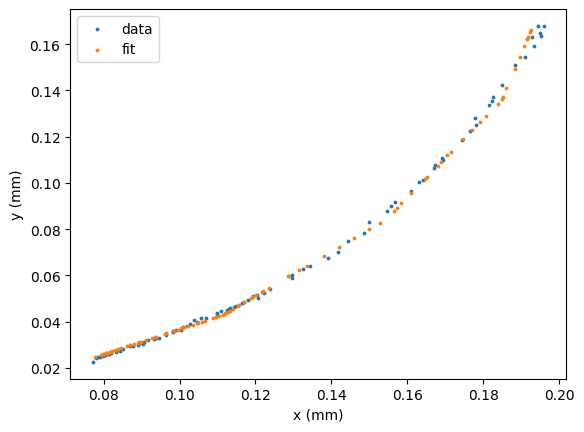

In [5]:
plt.scatter(cluster.data[:, 0], cluster.data[:, 1], s=3, label='data')
plt.scatter(best_fit_trajectory_xy[:, 0], best_fit_trajectory_xy[:, 1], s=3, label='fit')
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.legend()


Text(0, 0.5, 'y (mm)')

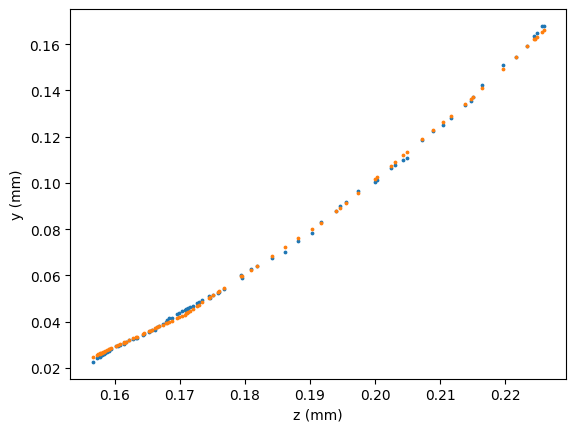

In [6]:
plt.scatter(cluster.data[:, 2], cluster.data[:, 1], s=3, label='data')
plt.scatter(cluster.data[:, 2], best_fit_trajectory_xy[:, 1], s=3, label='fit')
plt.xlabel("z (mm)")
plt.ylabel("y (mm)")


Text(0, 0.5, 'x (mm)')

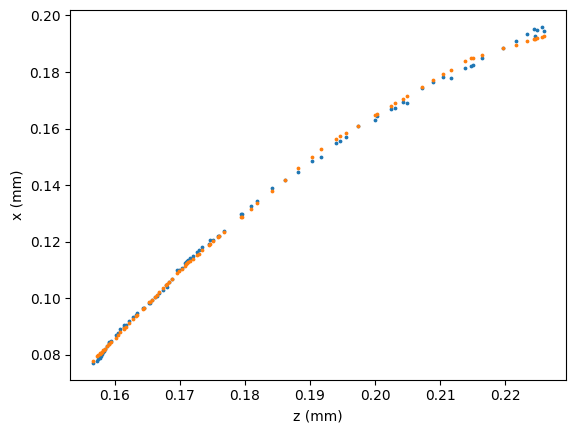

In [7]:
plt.scatter(cluster.data[:, 2], cluster.data[:, 0], s=3, label='data')
plt.scatter(cluster.data[:, 2], best_fit_trajectory_xy[:, 0], s=3, label='fit')
plt.xlabel("z (mm)")
plt.ylabel("x (mm)")

Hopefully you see a nice fit to the data! If the fit looks bad, there are several things to check. First is the particle ID gate; if the wrong particle group is selected, the fit will fail spectacularly. Another is the coarse-ness of the interpolation scheme. If there are too few bins in the polar angle or the particle kinetic energy, the interpolation may not generate good values. Finally, it is also good to make sure that the target gas is correctly defined with the right pressure and chemistry.